In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


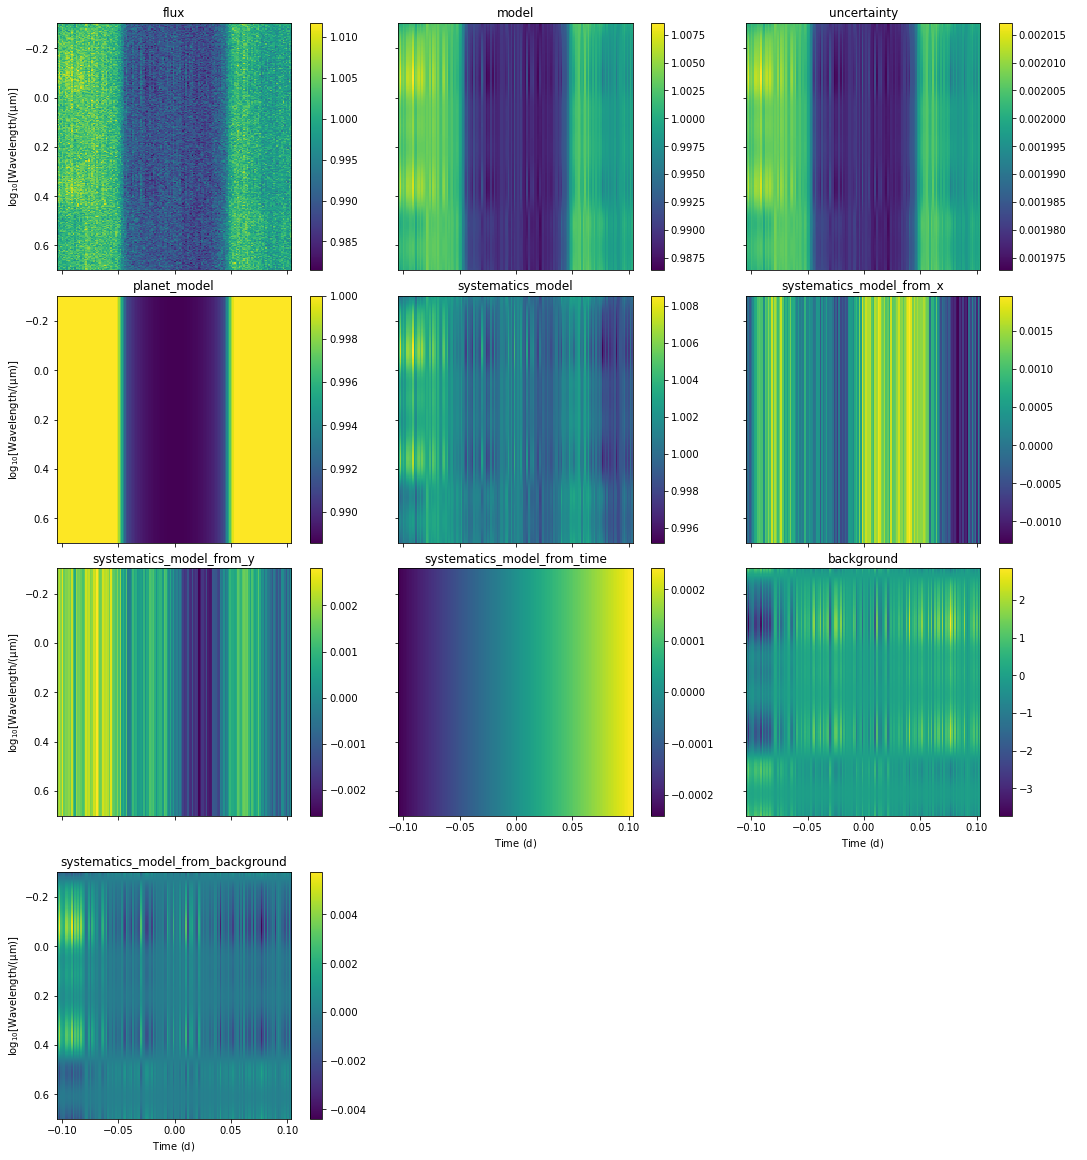

In [2]:
s = SimulatedRainbow().inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0 #Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

In [4]:
b_x.parameters

{'sx_p_0': <🧮 Fixed | 0.0 🧮>,
 'sx_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [5]:
b.parameters

{'stime_p_0': <🧮 Fixed | 1.0 🧮>,
 'stime_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [6]:
cm = t * (b + b_x + b_y + b_bkg)

In [7]:
cm

<chromatic combined model 🌈, models: stime(<chromatic polynomial model 🌈>) + sx(<chromatic polynomial model 🌈>) + sy(<chromatic polynomial model 🌈>) + sbkg(<chromatic polynomial model 🌈>) * transit(<chromatic transit model 🌈>)

In [8]:
cm.chromatic_models

{'stime': <chromatic polynomial model 🌈>,
 'sx': <chromatic polynomial model 🌈>,
 'sy': <chromatic polynomial model 🌈>,
 'sbkg': <chromatic polynomial model 🌈>,
 'transit': <chromatic transit model 🌈>}

In [9]:
cm.how_to_combine

['+', '+', '+', '*']

In [10]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 

In [11]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14324.81it/s]


In [12]:
print(cm.chromatic_models)
print()
print(cm.pymc3_model)

{'stime': <chromatic polynomial model 🌈>, 'sx': <chromatic polynomial model 🌈>, 'sy': <chromatic polynomial model 🌈>, 'sbkg': <chromatic polynomial model 🌈>, 'transit': <chromatic transit model 🌈>}

                            stime_p_1 ~ Normal
                               sx_p_1 ~ Normal
                               sy_p_1 ~ Normal
                             sbkg_p_1 ~ Normal
             transit_epoch_interval__ ~ TransformedDistribution
    transit_impact_parameter_impact__ ~ TransformedDistribution
    transit_stellar_radius_interval__ ~ TransformedDistribution
      transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_quadlimbdark__ ~ TransformedDistribution
              transit_radius_ratio_w0 ~ Normal
              transit_radius_ratio_w1 ~ Normal
              transit_radius_ratio_w2 ~ Normal
              transit_radius_ratio_w3 ~ Normal
              transit_radius_ratio_w4 ~ Normal
                        transit_epoch ~ Uniform
          

In [13]:
## combine the models - old method!
# cm = CombinedModel()
# cm.initialize_empty_model()
# cm.attach_models({'transit':t,'time':b,'x':b_x,'y':b_y,'background':b_bkg}) #'transit':t,
# cm.attach_data(s)
# cm.setup_lightcurves()
# cm.setup_likelihood()
# print(cm.chromatic_models)
# print(cm.pymc3_model)


🌈 Warning: invalid value encountered in log

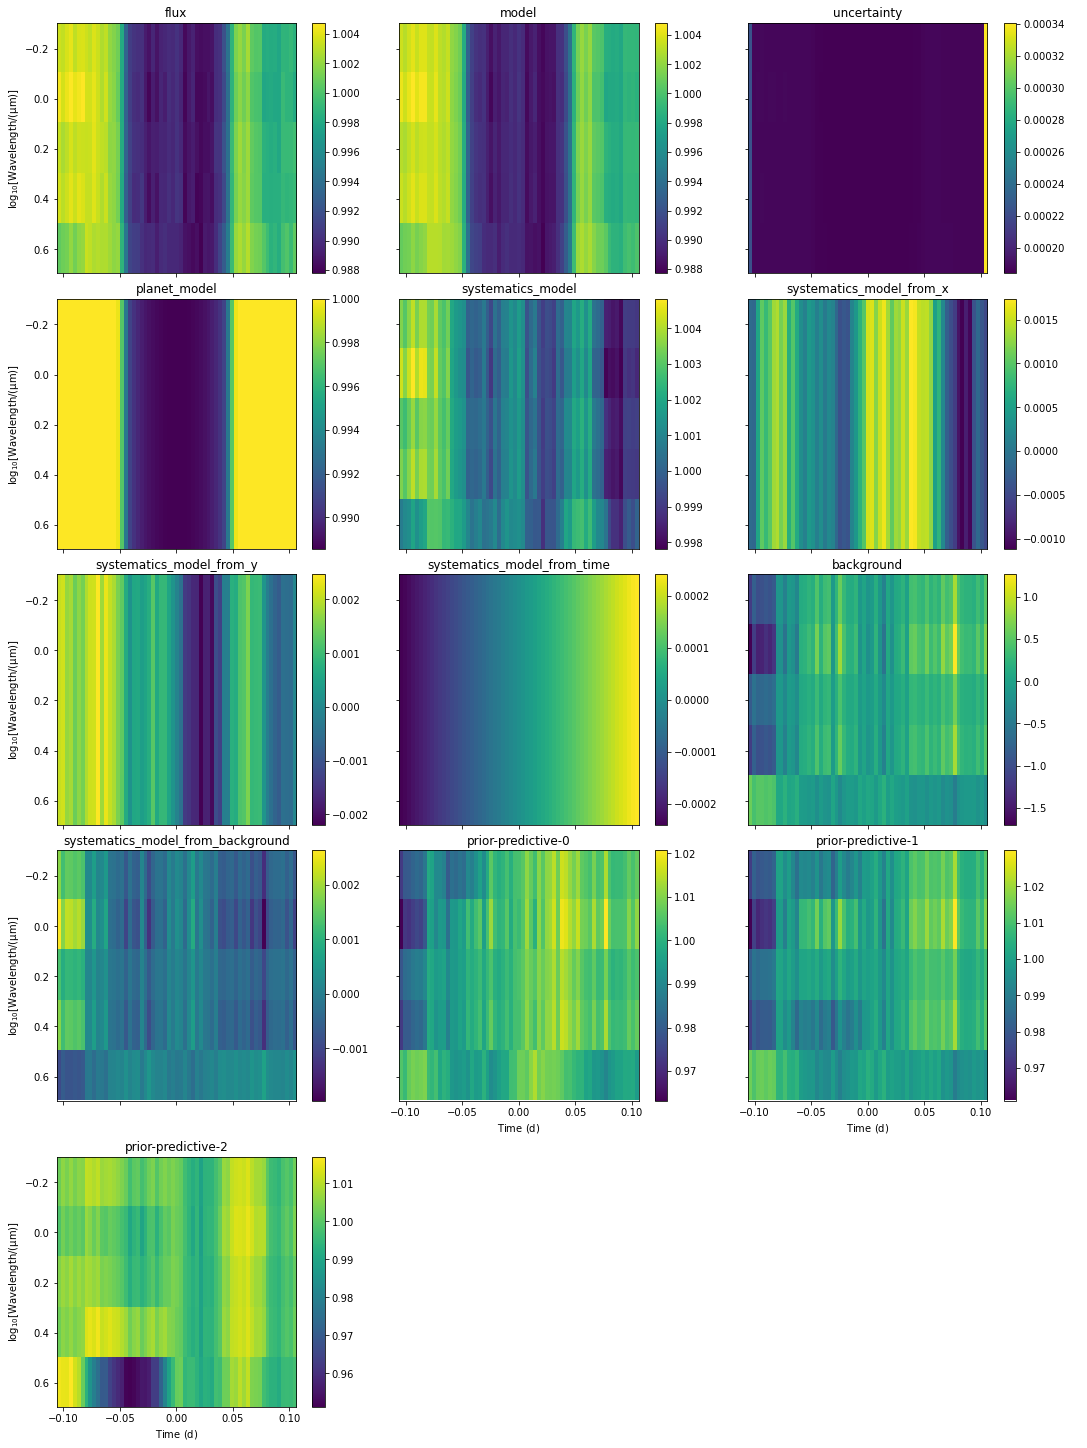

In [14]:
cm.plot_priors()

In [15]:
opt = cm.optimize()
cm.sample(start =opt, tune=4000, draws=4000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -48177.21763768309 -> -23692.249021636842

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 1424 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


                               mean        sd    hdi_3%   hdi_97%  \
stime_p_1                  0.002413  0.000284  0.001877  0.002946   
sx_p_1                     0.001188  0.000020  0.001151  0.001226   
sy_p_1                     0.001688  0.000018  0.001655  0.001723   
sbkg_p_1                  -0.001548  0.000033 -0.001609 -0.001486   
transit_radius_ratio_w0    0.100167  0.000335  0.099528  0.100781   
transit_radius_ratio_w1    0.100456  0.000337  0.099829  0.101082   
transit_radius_ratio_w2    0.100311  0.000335  0.099704  0.100953   
transit_radius_ratio_w3    0.100410  0.000340  0.099780  0.101054   
transit_radius_ratio_w4    0.100284  0.000338  0.099668  0.100920   
transit_epoch             -0.000046  0.000044 -0.000127  0.000036   
transit_impact_parameter   0.173405  0.059848  0.048406  0.268909   
transit_stellar_radius     1.187432  0.009092  1.171143  1.199999   
transit_stellar_mass       0.827408  0.020186  0.800008  0.864009   
transit_limb_darkening[0]  0.27867

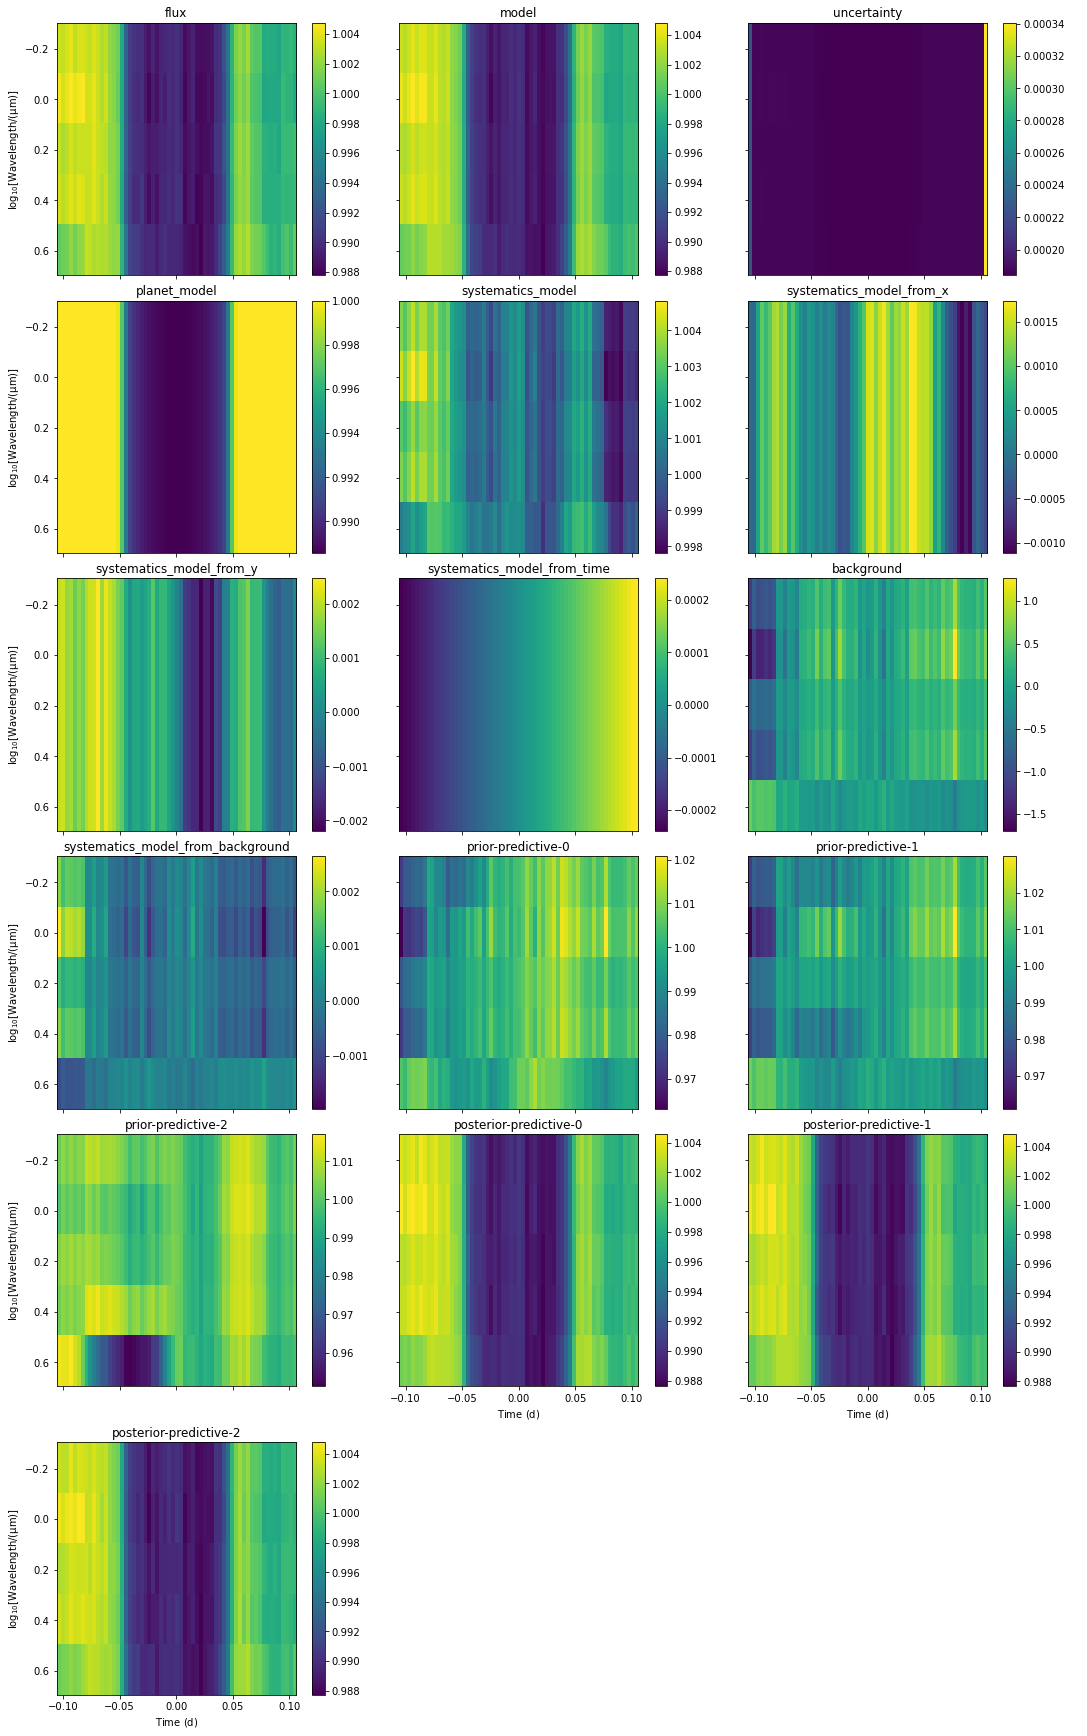

In [19]:
cm.plot_posteriors()

In [20]:
cm.summary['mean']

stime_p_1                    0.002413
sx_p_1                       0.001188
sy_p_1                       0.001688
sbkg_p_1                    -0.001548
transit_radius_ratio_w0      0.100167
transit_radius_ratio_w1      0.100456
transit_radius_ratio_w2      0.100311
transit_radius_ratio_w3      0.100410
transit_radius_ratio_w4      0.100284
transit_epoch               -0.000046
transit_impact_parameter     0.173405
transit_stellar_radius       1.187432
transit_stellar_mass         0.827408
transit_limb_darkening[0]    0.278672
transit_limb_darkening[1]    0.187228
Name: mean, dtype: float64

In [21]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = 0.0012115855829180678
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = 0.0016580006628073365
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = 0.00014006345472165796
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.001548333618490381
   offset_background = 0
    sigma_background = 1


In [34]:
def apply_operation_to_constituent_models(self, operation, *args, **kwargs):
    """
    Apply an operation to all models within a combined model
    """
    return_values = []
    for m in self.chromatic_models.values():
        try:
            # print(m, operation)
            op = getattr(m, operation)
            result = op(*args, **kwargs)
            if result is not None:
                return_values.append(result)
        except Exception as e:
            # print(m, operation)
            print(e)

    if len(return_values) > 0:
        return return_values

In [51]:
def get_results(self, as_df=True, uncertainty=["hdi_3%", "hdi_97%"]):
    for m in self.chromatic_models.values():
        m.summary = self.summary
            
    results = apply_operation_to_constituent_models(self,"get_results")
    return results

In [60]:
def transit_model(self, transit_params):
    data = self.get_data()

    orbit = xo.orbits.KeplerianOrbit(
            period=transit_params[f"{self.name}_period"],
            t0=transit_params[f"{self.name}_epoch"],
            b=transit_params[f"{self.name}_impact_parameter"],
            r_star=transit_params[f"{self.name}_stellar_radius"],
            m_star=transit_params[f"{self.name}_stellar_mass"],
    )
    ldlc = xo.LimbDarkLightCurve(transit_params[f"{self.name}_limb_darkening"]).get_light_curve(
            orbit=orbit,
            r=transit_params[f"{self.name}_radius_ratio"]
              * transit_params[f"{self.name}_stellar_radius"],
            t=list(data.time.to_value("day")),
    ).eval()
    return ldlc.transpose()[0] + transit_params[f"{self.name}_baseline"]

In [107]:
def polynomial_model(self, poly_params, i=0):
    data = self.get_data()
    poly = []
    x = data.get(self.independant_variable)
    if len(np.shape(x)) > 1:
        x = x[i, :]
    if self.independant_variable == "time":
        x = x.to_value("day")
        
    for d in range(self.degree + 1):
        print(f"{self.name}_p_{d}", poly_params[f"{self.name}_p_{d}"])
        poly.append(poly_params[f"{self.name}_p_{d}"] * (x ** d))
    return (np.sum(poly, axis=0))

In [59]:
results = pd.concat(get_results(cm),axis=1)
results

,stime_p_0,stime_p_0_hdi_3%,stime_p_0_hdi_97%,stime_p_1,stime_p_1_hdi_3%,stime_p_1_hdi_97%,wavelength,sx_p_0,sx_p_0_hdi_3%,sx_p_0_hdi_97%,...,transit_radius_ratio,transit_radius_ratio_hdi_3%,transit_radius_ratio_hdi_97%,transit_stellar_mass,transit_stellar_mass_hdi_3%,transit_stellar_mass_hdi_97%,transit_stellar_radius,transit_stellar_radius_hdi_3%,transit_stellar_radius_hdi_97%,wavelength
w0,1.0,1.0,1.0,0.002413,0.001877,0.002946,0.6427920004250605 micron,0.0,0.0,0.0,...,0.100167,0.099528,0.100781,0.827408,0.800008,0.864009,1.187432,1.171143,1.199999,0.6427920004250605 micron
w1,1.0,1.0,1.0,0.002413,0.001877,0.002946,1.0182498867257213 micron,0.0,0.0,0.0,...,0.100456,0.099829,0.101082,0.827408,0.800008,0.864009,1.187432,1.171143,1.199999,1.0182498867257213 micron
w2,1.0,1.0,1.0,0.002413,0.001877,0.002946,1.6129831557857937 micron,0.0,0.0,0.0,...,0.100311,0.099704,0.100953,0.827408,0.800008,0.864009,1.187432,1.171143,1.199999,1.6129831557857937 micron
w3,1.0,1.0,1.0,0.002413,0.001877,0.002946,2.5550846553145785 micron,0.0,0.0,0.0,...,0.10041,0.09978,0.101054,0.827408,0.800008,0.864009,1.187432,1.171143,1.199999,2.5550846553145785 micron
w4,1.0,1.0,1.0,0.002413,0.001877,0.002946,4.0474431319424164 micron,0.0,0.0,0.0,...,0.100284,0.099668,0.10092,0.827408,0.800008,0.864009,1.187432,1.171143,1.199999,4.0474431319424164 micron


In [123]:
wavelength = 'w2'
final_model = transit_model(cm.chromatic_models['transit'],results.loc[wavelength]) * \
                (polynomial_model(cm.chromatic_models['stime'],results.loc[wavelength]) + \
                polynomial_model(cm.chromatic_models['sx'],results.loc[wavelength]) + \
                polynomial_model(cm.chromatic_models['sy'],results.loc[wavelength]) + \
                polynomial_model(cm.chromatic_models['sbkg'],results.loc[wavelength]))
                
final_model

stime_p_0 1.0
stime_p_1 0.0024127
sx_p_0 0.0
sx_p_1 0.0011878
sy_p_0 0.0
sy_p_1 0.0016883
sbkg_p_0 0.0
sbkg_p_1 -0.0015477


array([1.00352834, 1.00301552, 1.00358904, 1.00416019, 1.0034156 ,
       1.00396533, 1.003961  , 1.00334794, 1.00329298, 1.00390249,
       1.00312684, 1.00283471, 1.0033298 , 1.0020353 , 1.00167564,
       1.00116133, 0.99813439, 0.99305375, 0.99101302, 0.99027707,
       0.99001104, 0.99014871, 0.98921439, 0.9884388 , 0.98939137,
       0.988836  , 0.98957864, 0.98956086, 0.99001739, 0.98970689,
       0.99020689, 0.98980355, 0.98816998, 0.98883995, 0.98928881,
       0.98835942, 0.98799264, 0.98851833, 0.98863676, 0.98861659,
       0.9900779 , 0.99018052, 0.99183411, 0.99408519, 0.99881453,
       1.00132766, 1.00218876, 1.00138306, 1.00211128, 1.00046686,
       1.00029982, 1.00005931, 0.99849055, 0.99841645, 0.9982234 ,
       0.99832077, 0.99798006, 0.99910786, 0.99904307, 0.99902818,
       0.99897561])

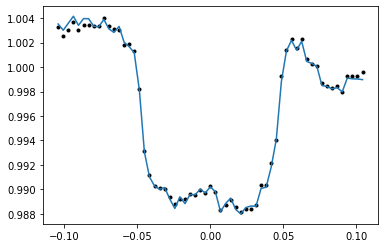

In [124]:
plt.plot(cm.data.time.to_value("day"), cm.data.flux[2,:],'k.')
plt.plot(cm.data.time.to_value("day"), final_model)

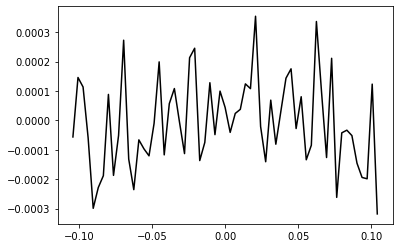

In [126]:
plt.plot(cm.data.time.to_value("day"), cm.data.flux[0,:]-final_model, 'k')

61

-8.258852741790262e-06 0.00015261360480603575
[-3.18188806e-04 -2.50972391e-04 -1.83755975e-04 -1.16539560e-04
 -4.93231452e-05  1.78932699e-05  8.51096850e-05  1.52326100e-04
  2.19542515e-04  2.86758930e-04  3.53975345e-04]


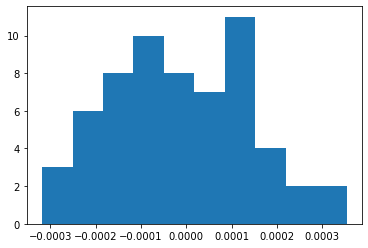

In [150]:
from scipy.stats import norm

# best fit of data
(mu, sigma) = norm.fit(cm.data.flux[0,:]-final_model)
print(mu, sigma)

n, bins, patches = plt.hist(cm.data.flux[0,:]-final_model)
print(bins)

# add a 'best fit' line
# y = norm.pdf(bins, loc=mu, scale=sigma)
# l = plt.plot(bins, y, 'r--', linewidth=2)

In [188]:
def rmsValue(arr):
    n = len(arr)
    square = 0
    mean = 0.0
    root = 0.0
     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean
    mean = (square / n)
     
    #Calculate Root
    root = math.sqrt(mean)
     
    return root

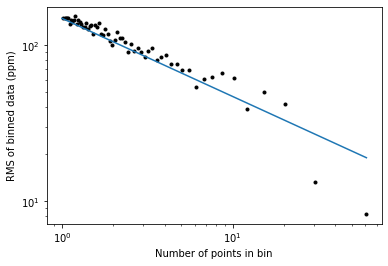

In [220]:
from scipy.stats import binned_statistic

x, y = [], []
detrended_y = cm.data.flux[0,:]-final_model
for i in range(1,61):
    ret = binned_statistic(cm.data.time, detrended_y, statistic='mean', bins=i)
    ret_count = binned_statistic(cm.data.time, detrended_y, statistic='count', bins=i)
    y.append((10**6) * np.sqrt(np.sum(ret.statistic**2)/len(ret.statistic)))
    x.append(np.nanmean(ret_count.statistic))

offset = y[-1]
    
xmodel = np.linspace(1,61)
plt.loglog(x, y,'k.');
plt.ylabel("RMS of binned data (ppm)")
plt.xlabel("Number of points in bin")
plt.loglog(xmodel, offset * (1/np.sqrt(xmodel)));

In [203]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = 0.0012115855829180678
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = 0.0016580006628073365
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = 0.00014006345472165796
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.001548333618490381
   offset_background = 0
    sigma_background = 1


In [67]:
cm.data.fluxlike['test_planet_recovered-0'] = cm.data.fluxlike['posterior-predictive-0'] - cm.data.fluxlike['systematics_model']
cm.data.fluxlike['test_residuals-0'] = 1 + cm.data.fluxlike['posterior-predictive-0'] - cm.data.fluxlike['systematics_model'] - cm.data.fluxlike['planet_model']

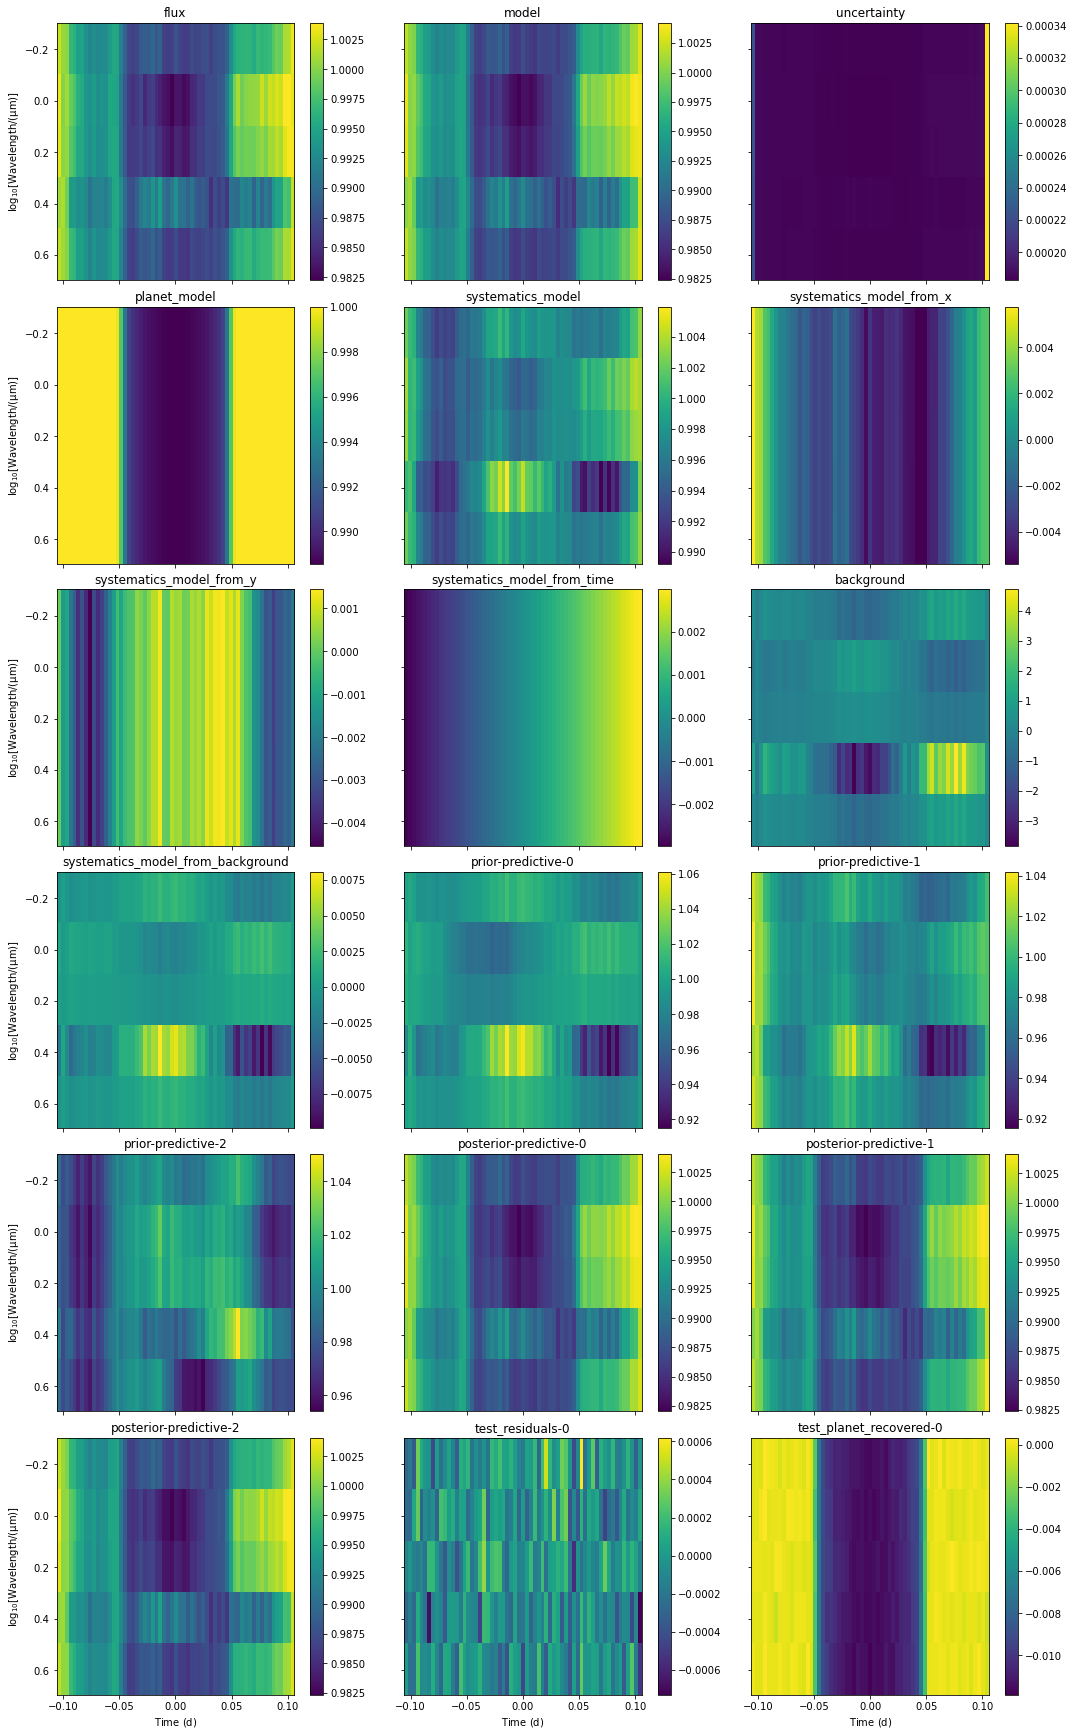

In [68]:
cm.data.imshow_quantities()

# Testing!

optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -52849.34418438209 -> 2223.3164028857623

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002051 -0.003559 -0.000538  -0.001925
recovered  0.002052 -0.003584 -0.000533  -0.001886 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -52849.34418438209 -> 2223.316402885762



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002051 -0.003559 -0.000538  -0.001925
recovered -0.002052  0.003583  0.000533  -0.001892 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -56100.03858355301 -> 2201.446194789077



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003154  0.000190  0.004020   0.027577
recovered -0.003148  0.000211  0.004041   0.027611 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -56100.03858355301 -> 2201.4461947890773



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003154  0.000190  0.004020   0.027577
recovered  0.003148 -0.000211 -0.004041   0.027609 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -36621.243797121584 -> 2222.179626428143



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.001144 -0.002010  0.001334   0.011351
recovered -0.001136 -0.002014  0.001333   0.011186 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -36621.243797121584 -> 2222.179626428143



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.001144 -0.002010  0.001334   0.011351
recovered  0.001136  0.002014 -0.001333   0.011190 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -8560.56691610655 -> 2220.88993939168



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.

KeyboardInterrupt



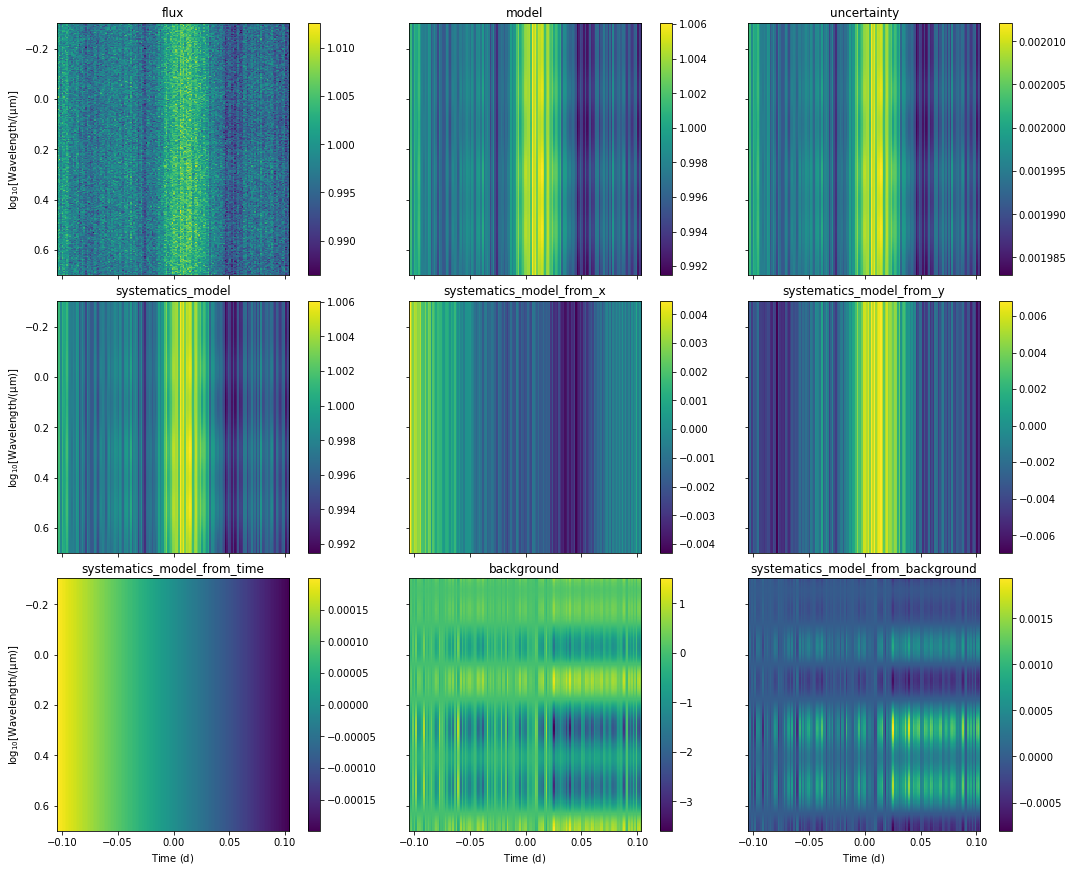

In [ ]:
for i in range(10):
    # create simulated rainbow + noise
    s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
    s.imshow_quantities();
    s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)
    
    cm = b + b_x + b_y + b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
#     print(cm.chromatic_models)
#     print(cm.pymc3_model)
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")
    
    cm = b - b_x - b_y - b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")

In [11]:
a = {'bla':30,'new':2}
b = {'bla':40}

In [12]:
subtract_dicts(a,b)

{'bla': 10, 'new': 2}

In [21]:
c = {**b,**a}
c

{'bla': 30, 'new': 2}

In [22]:
for key, value in c.items():
    if key in a and key in b:
        c[key] = value - b[key]

In [23]:
c

{'bla': -10, 'new': 2}